<a href="https://colab.research.google.com/github/harishk30/DwarfResearch/blob/main/SAGAxCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
pip install colossus

In [15]:
from colossus.halo import mass_so
from colossus.halo import mass_defs
from colossus.halo.concentration import concentration
from colossus.halo import profile_nfw
from colossus.halo import mass_adv
from colossus.cosmology import cosmology

In [16]:
import pandas as pd
import astropy.coordinates
from astropy.coordinates import SkyCoord
import numpy as np
from astropy import units as u
from astropy.cosmology import Planck15 as cosmo

In [17]:
from tqdm import tqdm

In [18]:
cosmology.setCosmology('planck15')

In [19]:
saga_hosts = '/content/drive/MyDrive/SummerProject/xSAGA-hosts_2021-09-28.parquet'
hosts = pd.read_parquet(saga_hosts, engine = 'auto')
satellites = pd.read_csv('/content/drive/MyDrive/SummerProject/xSAGA-lowz_2021-08-30.csv')

In [26]:
hosts = hosts.sort_values('mass_NSA', ascending = False)

In [27]:
#hosts = hosts[hosts['mass_GSE'] < 11]
satellite_coords = SkyCoord(satellites['ra'], satellites['dec'], unit = 'deg')
host_coords = SkyCoord(hosts['ra_NSA'], hosts['dec_NSA'], unit = 'deg')

In [28]:
host_coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(157.16630741, 14.33506305), (247.43729829, 40.811602  ),
     (181.66246902, 28.17453522), ..., (214.9766162 , 51.89505011),
     (173.53809004, -1.59561628), (208.34098059, 20.94890988)]>

In [34]:
UniverseMachine_params = {
    "alpha": 1.957,
    "beta": 0.474,
    "gamma": -1.065,
    "delta": 0.386,
    "epsilon": -1.435,
    "M0": 12.081,
}

def SHMR(M_halo, params):
    """Stellar Mass Halo Mass Relation from Behroozi+19. See Appendix J."""

    x = M_halo - params["M0"]

    return (
        params["M0"] + params["epsilon"]
        - np.log10(10**(-params["alpha"]*x) + 10**(-params["beta"]*x))
        + 10**params["gamma"]*np.exp(-0.5 * (x / params["delta"])**2)
    )

In [35]:
halo_masses = np.arange(11, 15, 0.001)
stellar_masses = SHMR(halo_masses, UniverseMachine_params)

In [36]:
def virial_mass(sm):
  return halo_masses[np.argmin((sm - stellar_masses)**2)]

In [37]:
def virial_radius(sm, z):
  vm = virial_mass(sm)
  return mass_so.M_to_R(10 ** vm, z, 'vir')

In [38]:
def r_to_deg(r, z):
  return (r * u.kpc / cosmo.kpc_proper_per_arcmin(z)).to(u.arcmin)

In [39]:
pairs = {}
assigned_satellites = set()
for id, host_coord in enumerate(tqdm(host_coords)):
  vr = virial_radius(hosts.iloc[id]['mass_NSA'], hosts.iloc[id]['z_NSA'])
  va = r_to_deg(vr, hosts.iloc[id]['z_NSA'])
  host_coord = SkyCoord(ra = [host_coords[id].ra], dec = [host_coords[id].dec])
  host_idx, satellite_idx, angsep, _ = host_coord.search_around_sky(satellite_coords, va)
  sep = (angsep * cosmo.kpc_proper_per_arcmin(hosts.iloc[id].z_NSA)).to(u.kpc)
  pairs[hosts.index[id]] = []
  for i, satellite_val in enumerate(host_idx):
    if(sep[i] > 36 * u.kpc):
      if(satellite_val not in assigned_satellites):
        pairs[hosts.index[id]].append(satellites.iloc[satellite_val]['objID'])
        assigned_satellites.add(satellite_val)

100%|██████████| 12769/12769 [44:23<00:00,  4.79it/s]


In [43]:
for i in range(0, len(hosts)):
  if(hosts.iloc[i]['mass_NSA'] > 11):
    del pairs[hosts.index[i]]

In [44]:
pairs

{350702: [1.237662528993952e+18,
  1.2376625289938214e+18,
  1.237662528993952e+18,
  1.237662635828839e+18,
  1.2376625289939523e+18],
 352469: [1.2376621988189312e+18,
  1.2376619491977467e+18,
  1.237662198818931e+18,
  1.2376621988188654e+18,
  1.2376619491976814e+18,
  1.237662198818931e+18,
  1.237662198818931e+18,
  1.2376619491977462e+18,
  1.2376621988188657e+18,
  1.2376621988189307e+18,
  1.237661949197681e+18,
  1.237662198818931e+18,
  1.2376619491976812e+18,
  1.237662198818931e+18,
  1.2376619491977462e+18,
  1.237662198818931e+18,
  1.2376621988189307e+18,
  1.2376621988189312e+18],
 522694: [1.2376682944497585e+18,
  1.2376682944497582e+18,
  1.2376682944497585e+18,
  1.2376682944498895e+18,
  1.2376682944497585e+18,
  1.2376679164906048e+18,
  1.2376679164906045e+18,
  1.2376682944497582e+18,
  1.2376679164906048e+18,
  1.2376682944498895e+18],
 123564: [1.237656494033273e+18,
  1.2376564940332736e+18,
  1.2376529420949266e+18,
  1.237656494033339e+18,
  1.23765294209

In [45]:
import csv

w = csv.writer(open("hostpairs.csv", "w"))

for key, val in pairs.items():

    w.writerow([key, val])

In [76]:
hosts = hosts[hosts['mass_NSA'] <= 11]

In [77]:
n_sat = []

In [78]:
for i in range(0, len(hosts)):
  if hosts.index[i] in pairs:
    n_sat.append(len(pairs[hosts.index[i]]))
  else:
    n_sat.append(0)

In [ ]:
hosts[n_sat] = n_sat

In [86]:
hosts['n_sat']

NSAID
350702     5
352469    18
522694    10
123564     7
402395     2
          ..
120181     0
325710     0
223226     0
208673     0
17347      0
Name: n_sat, Length: 12749, dtype: int64

In [91]:
bin1 = []
bin2 = []
bin3 = []
bin4 = []

In [97]:
for i in range(0, len(hosts)):
  val = hosts.iloc[i]
  if(val['mass_NSA'] < 9.5 and val['mass_NSA'] >= 9):
    bin1.append(val['n_sat'])
  elif(val['mass_NSA'] < 10 and val['mass_NSA'] >= 9.5):
    bin2.append(val['n_sat'])
  elif(val['mass_NSA'] < 10.5 and val['mass_NSA'] >= 10):
    bin3.append(val['n_sat'])
  else:
    bin4.append(val['n_sat'])

Text(0, 0.5, 'Average Satellites')

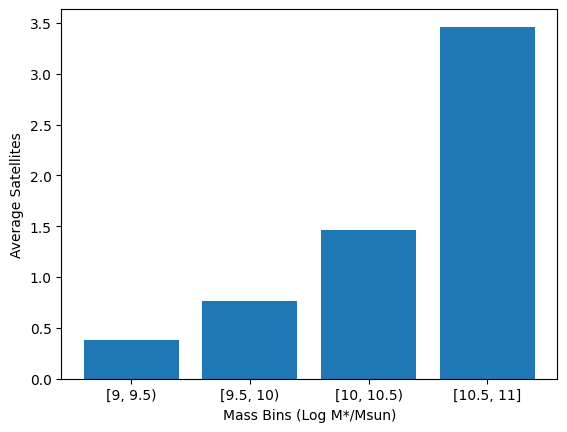

In [106]:
import matplotlib.pyplot as plt
groups = ['[9, 9.5)', '[9.5, 10)', '[10, 10.5)', '[10.5, 11]']
values = [sum(bin1)/len(bin1), sum(bin2)/len(bin2), sum(bin3)/len(bin3), sum(bin4)/len(bin4)]
plt.bar(groups, values)
plt.xlabel('Mass Bins (Log M*/Msun)')
plt.ylabel('Average Satellites')

Text(0, 0.5, 'Frequency')

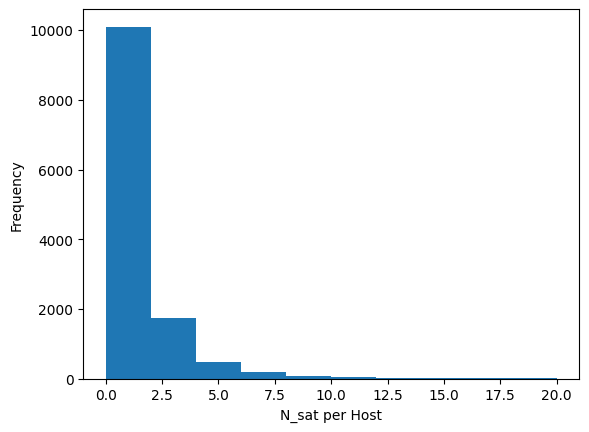

In [111]:
plt.hist(n_sat, bins = 10, range = (0, 20))
plt.xlabel('N_sat per Host')
plt.ylabel('Frequency')

In [118]:
hosts['M_g_NSA']

NSAID
350702   -21.269285
352469   -21.470406
522694   -21.289984
123564   -21.223104
402395   -21.175783
            ...    
120181   -19.393631
325710   -17.478563
223226    -9.839364
208673          inf
17347           inf
Name: M_g_NSA, Length: 12749, dtype: float32